In [ ]:
# IMPORTS AND INITIAL SETUP ALONG WITH LOADING DATASET

In [1]:
import torch
from torchvision import datasets, transforms
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations are defined
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing the data
])

# Augmentations for training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

device

100%|██████████| 169001437/169001437 [00:01<00:00, 94906213.31it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


device(type='cuda')

In [2]:
# DATA PREPARATION

In [3]:
from torch.utils.data import random_split

# Splitting the training data into training and validation sets
num_train = int(len(train_data) * 0.8)
num_val = len(train_data) - num_train
train_dataset, val_dataset = random_split(train_data, [num_train, num_val])

# DataLoader for the validation set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
# EARLY STOPPING CLASS:- The `EarlyStopping` class stops training if the validation loss doesn't get better after a predetermined number of epochs, preventing overfitting. By stopping training at an appropriate time, this method reduces the amount of computational resources used while improving the model's generalization on new, unknown data.

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last time validation accuracy improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation accuracy improvement.
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = float('-inf')

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score <= self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation accuracy increase.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_accuracy:.6f}).  Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_acc_max = val_accuracy

In [26]:
# Model, loss, and optimizer
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, epochs=30):
    """Train and evaluate the model, record accuracies."""
    model.to(device)
    history = {'train_acc': [], 'val_acc': []}
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_correct, train_total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        history['train_acc'].append(train_acc)

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        history['val_acc'].append(val_acc)
        
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    return history

In [27]:
# CNN MODEL FOR CIPHAR-100

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Sequential container for convolutional layers utilizing max pooling to reduce spatial dimensions after batch normalization and ReLU activation
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Sequential container with dropout and ReLU activation for completely linked layers
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 100)  # 100 classes in CIFAR-100
        )

    def forward(self, x):
        # Apply the Conv layers
        x = self.conv_layer(x)
        # Flatten the output for the layers which are fully connected
        x = x.view(x.size(0), -1)
        # FC layers are applied
        x = self.fc_layer(x)
        return x

# Model to device
cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [32]:
cnn_model = nn.DataParallel(cnn_model)

In [33]:
criterion = nn.CrossEntropyLoss()  #setting up a loss function and optimizer for training a CNN model
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [34]:
# MODEL TRAINING AND VALIDATION

In [35]:
history = train_and_evaluate(cnn_model, criterion, optimizer, train_loader, val_loader, 50)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation accuracy increased (-inf --> 8.210000).  Saving model...
Epoch [1/50], Train Acc: 6.08%, Val Acc: 8.21%
Validation accuracy increased (8.210000 --> 10.570000).  Saving model...
Epoch [2/50], Train Acc: 8.32%, Val Acc: 10.57%
Validation accuracy increased (10.570000 --> 12.540000).  Saving model...
Epoch [3/50], Train Acc: 10.29%, Val Acc: 12.54%
Validation accuracy increased (12.540000 --> 15.400000).  Saving model...
Epoch [4/50], Train Acc: 12.66%, Val Acc: 15.40%
Validation accuracy increased (15.400000 --> 19.440000).  Saving model...
Epoch [5/50], Train Acc: 15.73%, Val Acc: 19.44%
Validation accuracy increased (19.440000 --> 22.650000).  Saving model...
Epoch [6/50], Train Acc: 18.40%, Val Acc: 22.65%
Validation accuracy increased (22.650000 --> 24.670000).  Saving model...
Epoch [7/50], Train Acc: 21.07%, Val Acc: 24.67%
Validation accuracy increased (24.670000 --> 26.230000).  Saving model...
Epoch [8/50], Train Acc: 23.22%, Val Acc: 26.23%
Validation accuracy increa

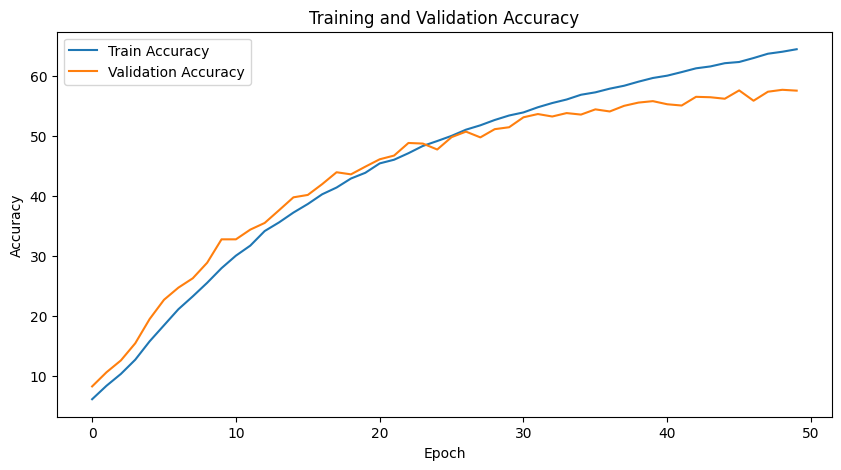

In [37]:
from matplotlib import pyplot as plt
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Assuming history is the output from train_and_evaluate
plot_accuracy(history)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precision: 0.6266, Recall: 0.6180


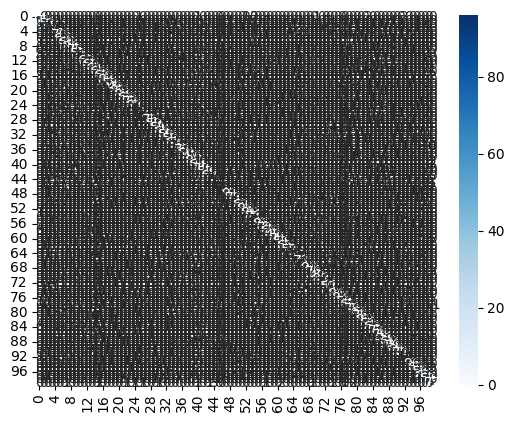

In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
def evaluate_metrics(model, loader):
    y_pred, y_true = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Compute metrics
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.show()

# Call this function with test_loader after model training
evaluate_metrics(cnn_model, test_loader)


In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) #First layer of convolution with a certain stride
        self.bn1 = nn.BatchNorm2d(out_channels) #Batch normalization after the first convolution
        self.relu = nn.ReLU(inplace = True) #ReLU activation function
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False) #Second layer of convolution with stride 1, without bias
        self.bn2 = nn.BatchNorm2d(out_channels) #Batch normalization
        self.downsample = downsample #downsample to adjust channels and dimensions

    def forward(self, x):
        residual = x
        out = self.conv1(x) #convulation 1 operation
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out) #convulation 2 operation
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [39]:
# RESNET MODEL FOR CIPHAR-100

In [40]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # Set the initial convolution, batch normalization, and input channel initialization
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Layers of residual blocks are defined
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Pooling that adapts to output size
        self.fc = nn.Linear(512, 100) # Final linear layer for classification

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None  # If necessary, configure the downsample for the remaining connection.
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []

        # Creating blocks of residual layers
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):  # Activation, normalization, and initial convolution
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [41]:
resnet_model = nn.DataParallel(ResNet()).to(device)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(resnet_model)

DataParallel(
  (module): ResNet(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64

In [42]:
resnet_history = train_and_evaluate(resnet_model, criterion, optimizer, train_loader, val_loader, 50)  # model training and validation

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation accuracy increased (-inf --> 12.810000).  Saving model...
Epoch [1/50], Train Acc: 8.22%, Val Acc: 12.81%
Validation accuracy increased (12.810000 --> 21.490000).  Saving model...
Epoch [2/50], Train Acc: 17.32%, Val Acc: 21.49%
Validation accuracy increased (21.490000 --> 28.950000).  Saving model...
Epoch [3/50], Train Acc: 25.30%, Val Acc: 28.95%
Validation accuracy increased (28.950000 --> 35.830000).  Saving model...
Epoch [4/50], Train Acc: 32.11%, Val Acc: 35.83%
Validation accuracy increased (35.830000 --> 38.790000).  Saving model...
Epoch [5/50], Train Acc: 38.17%, Val Acc: 38.79%
Validation accuracy increased (38.790000 --> 42.630000).  Saving model...
Epoch [6/50], Train Acc: 42.87%, Val Acc: 42.63%
Validation accuracy increased (42.630000 --> 45.400000).  Saving model...
Epoch [7/50], Train Acc: 46.63%, Val Acc: 45.40%
Validation accuracy increased (45.400000 --> 48.310000).  Saving model...
Epoch [8/50], Train Acc: 50.16%, Val Acc: 48.31%
Validation accuracy in

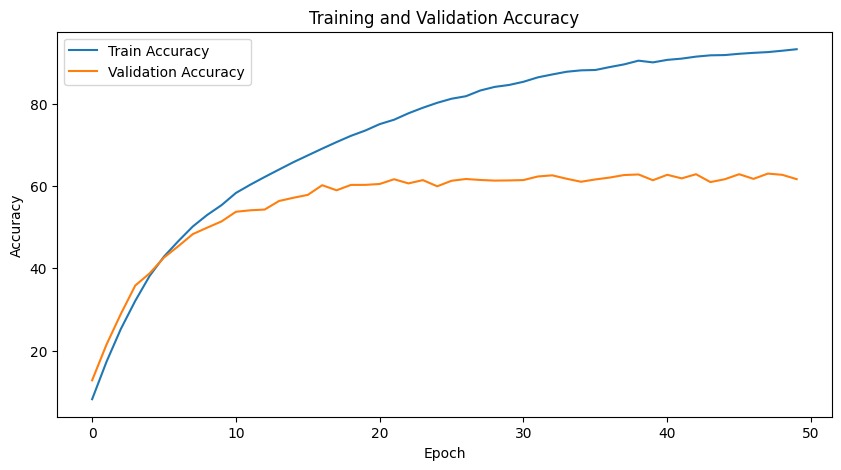

In [46]:
plot_accuracy(resnet_history)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precision: 0.6540, Recall: 0.6460


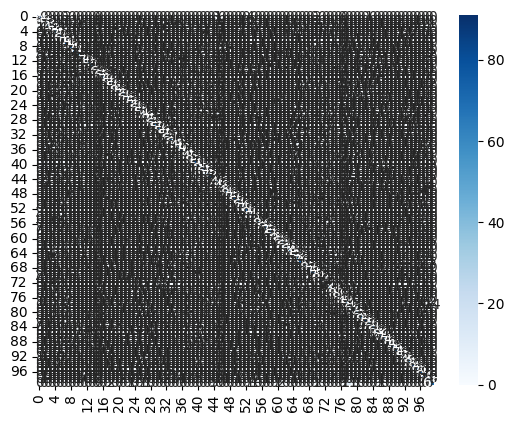

In [47]:
evaluate_metrics(resnet_model, test_loader)

In [48]:
# VGG MODEL FOR CIPHAR-100

In [49]:
class VGG16CIFAR100(nn.Module):
    def __init__(self):
        super(VGG16CIFAR100, self).__init__()
        # Setting up VGG-like layers with max pooling ('M') after convolutions
        self.features = self._make_layers([
            64, 64, 'M',      # 'M' stands for MaxPool
            128, 128, 'M',
            256, 256, 256, 'M',
            512, 512, 512, 'M',
            512, 512, 512, 'M'
        ])
        # Fully connected layers are used for classification, while dropout is used for regularization in the classifier.
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 100)  # CIFAR-100 has 100 classes
        )

    def forward(self, x):
        x = self.features(x) # Through feature extractor input is passed and output is flattend in order to feed into the classifier
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3  # Input channels (RGB)
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

In [50]:
vgg_model = nn.DataParallel(VGG16CIFAR100()).to(device)  # Set up the VGG16 model that was modified to work with the CIFAR-100 dataset
print(vgg_model)

DataParallel(
  (module): VGG16CIFAR100(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2,

In [51]:
vgg_history = train_and_evaluate(vgg_model, criterion, optimizer, train_loader, val_loader, 50)  # model training and validation

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation accuracy increased (-inf --> 1.070000).  Saving model...
Epoch [1/50], Train Acc: 0.96%, Val Acc: 1.07%
Validation accuracy increased (1.070000 --> 1.080000).  Saving model...
Epoch [2/50], Train Acc: 0.96%, Val Acc: 1.08%
Validation accuracy increased (1.080000 --> 1.090000).  Saving model...
Epoch [3/50], Train Acc: 1.04%, Val Acc: 1.09%
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Acc: 1.05%, Val Acc: 1.09%
Validation accuracy increased (1.090000 --> 1.110000).  Saving model...
Epoch [5/50], Train Acc: 1.06%, Val Acc: 1.11%
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Acc: 0.91%, Val Acc: 0.97%
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Acc: 1.01%, Val Acc: 1.05%
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Acc: 1.01%, Val Acc: 1.05%
EarlyStopping counter: 4 out of 5
Epoch [9/50], Train Acc: 1.04%, Val Acc: 0.99%
EarlyStopping counter: 5 out of 5
Early stopping


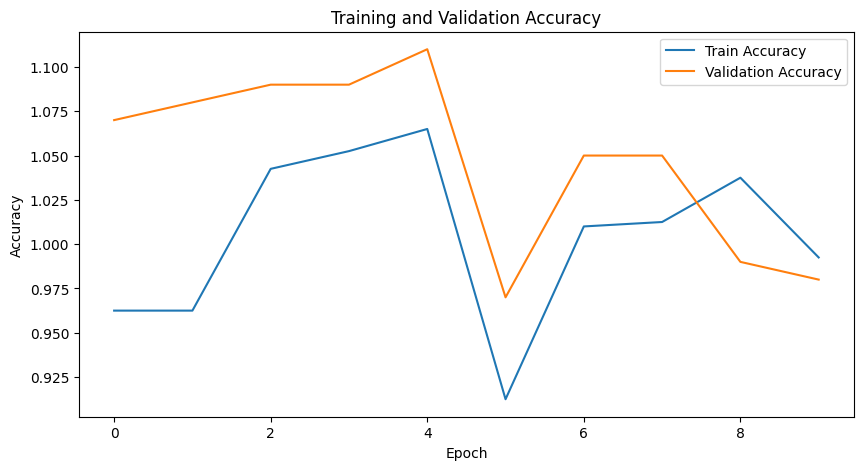

In [52]:
plot_accuracy(vgg_history)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0112, Recall: 0.0103


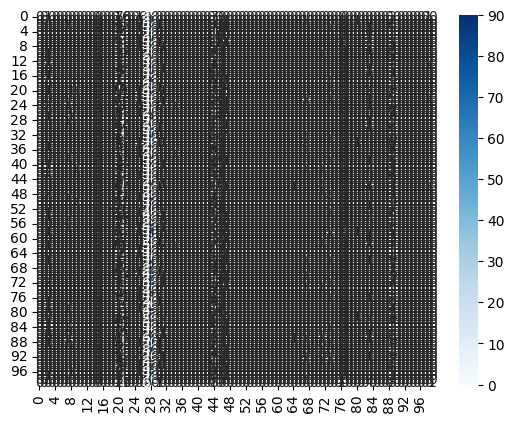

In [53]:
evaluate_metrics(vgg_model, test_loader)

In [55]:
# Convert to numpy arrays for compatibility with scikit-learn
def convert_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset:
        image = image.permute(1, 2, 0).numpy()  # Reorder dimensions to HWC
        image = image.flatten()  # Flatten the image
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = convert_to_numpy(train_data)
X_test, y_test = convert_to_numpy(test_data)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [56]:
# SVM MODEL TRAINING FOR CIPHAR-100

In [ ]:
# Function to train and evaluate SVM
def train_svm(kernel_type):
    print(f"Training SVM with {kernel_type} kernel...")
    svm_model = svm.SVC(kernel=kernel_type)
    svm_model.fit(X_train_scaled, y_train)

    # Predict and evaluate on the validation set
    y_val_pred = svm_model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='macro')  # 'macro' average for multiclass
    val_recall = recall_score(y_val, y_val_pred, average='macro')  # 'macro' average considers all classes equally

    # Print the results
    print(f"Validation accuracy for {kernel_type} kernel: {val_accuracy:.4f}")
    print(f"Validation precision for {kernel_type} kernel: {val_precision:.4f}")
    print(f"Validation recall for {kernel_type} kernel: {val_recall:.4f}")

# Train SVM with linear kernel
train_svm('linear')

# Train SVM with radial kernel
train_svm('rbf')

Training SVM with linear kernel...
Validation accuracy for linear kernel: 0.0823
Validation precision for linear kernel: 0.0735
Validation recall for linear kernel: 0.0815
Training SVM with rbf kernel...
